In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error


%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('float_format', '{:2f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading the file and type casting

In [4]:
loan = pd.read_csv('loan-DS-Test.csv', index_col='UniqueID',parse_dates=['DisbursalDate','Date.of.Birth'])
print(loan.shape)
loan.head()

(90983, 40)


,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
UniqueID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.550000,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.230000,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.630000,67,22807,45,1497,1985-08-24,Self employed,2018-01-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.480000,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.390000,67,22807,45,1495,1977-09-12,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90983 entries, 420825 to 512888
Data columns (total 40 columns):
disbursed_amount                       90983 non-null int64
asset_cost                             90983 non-null int64
ltv                                    90983 non-null float64
branch_id                              90983 non-null int64
supplier_id                            90983 non-null int64
manufacturer_id                        90983 non-null int64
Current_pincode_ID                     90983 non-null int64
Date.of.Birth                          90983 non-null datetime64[ns]
Employment.Type                        87476 non-null object
DisbursalDate                          90983 non-null datetime64[ns]
State_ID                               90983 non-null int64
Employee_code_ID                       90983 non-null int64
MobileNo_Avl_Flag                      90983 non-null int64
Aadhar_flag                            90983 non-null int64
PAN_flag                

In [6]:
loan.nunique()

disbursed_amount                       14197
asset_cost                             27565
ltv                                     5870
branch_id                                 55
supplier_id                             1728
manufacturer_id                           10
Current_pincode_ID                      4189
Date.of.Birth                          13575
Employment.Type                            2
DisbursalDate                             84
State_ID                                  18
Employee_code_ID                         906
MobileNo_Avl_Flag                          1
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PERFORM_CNS.SCORE                        563
PERFORM_CNS.SCORE.DESCRIPTION             20
PRI.NO.OF.ACCTS                           85
PRI.ACTIVE.ACCTS                          34
PRI.OVERDU

Some of the feature are binary (bool), some categorical and some continuous. I noticed that `MobileNo_Avl_Flag` has only one value and won't add value to the model so I'll drop it.

In [7]:
loan.drop(columns='MobileNo_Avl_Flag',inplace=True)

I'll cast `AVERAGE.ACCT.AGE` and `CREDIT.HISTORY.LENGTH` features to integers so I could use them later in the analysis and modeling.

In [8]:
loan['AVERAGE_ACCT_AGE(mon)'] = loan['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype(int) + (loan['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype(int) * 12)
loan.drop(columns='AVERAGE.ACCT.AGE', inplace=True)

loan['CREDIT_HISTORY_LENGTH(mon)'] = loan['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype(int) + (loan['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype(int) * 12)
loan.drop(columns='CREDIT.HISTORY.LENGTH', inplace=True)

converting features to categorical:

In [9]:
loan['branch_id'] = loan['branch_id'].astype(object)
loan['supplier_id'] = loan['supplier_id'].astype(object)
loan['manufacturer_id'] = loan['manufacturer_id'].astype(object)
loan['Current_pincode_ID'] = loan['Current_pincode_ID'].astype(object)
loan['State_ID'] = loan['State_ID'].astype(object)
loan['Employee_code_ID'] = loan['Employee_code_ID'].astype(object)

### Checking for missing values:

In [10]:
loan.isna().sum().sort_values(ascending=False)[loan.isna().sum()>0]

Employment.Type    3507
dtype: int64

In [11]:
loan['Employment.Type'].value_counts()

Self employed    47606
Salaried         39870
Name: Employment.Type, dtype: int64

only one columns contains missing values. I'll handle it later

### EDA & Preprocessing:

It looks like the loans in the dataset are for property\asset purchase. The finance institution doesn't release the money all at once, but rather in portions (`disbursed_amount`)  

In [12]:
# checking the the asset cost always graeter then the disbursed amounts:
(loan.asset_cost > loan.disbursed_amount).all()

True

**State exploration:**

In [13]:
loan.State_ID.value_counts(normalize=True)[:10]

4    0.227196
3    0.208248
6    0.133739
13   0.078146
5    0.071332
14   0.052922
9    0.042316
8    0.028489
1    0.026796
10   0.021806
Name: State_ID, dtype: float64

In [14]:
# pivoting asset cost by state and employment type:

State_emp_type = loan.pivot_table(index='State_ID',
                                columns='Employment.Type',
                                values='asset_cost',
                                aggfunc='mean')
State_emp_type.head()

Employment.Type,Salaried,Self employed
State_ID,,
1,65829.673650,65107.622483
2,68528.000818,71002.922118
3,82904.533372,84306.525433
4,75417.293916,74860.637702
5,78266.483673,74826.263024


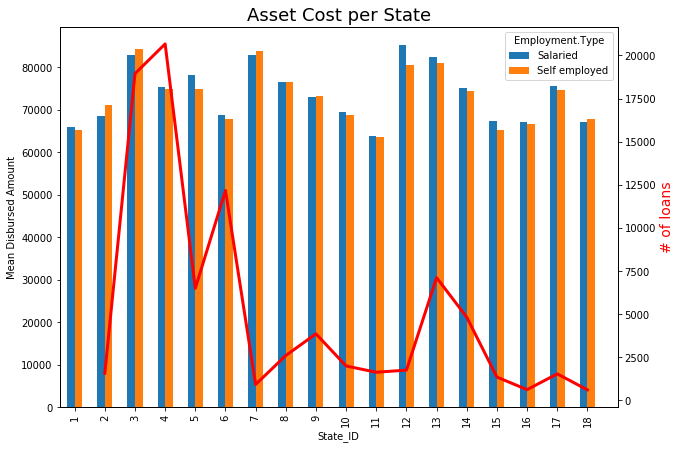

In [15]:
fig, ax1 = plt.subplots(1,1)

State_emp_type.plot(ax=ax1, kind='bar',figsize=(10,7))
plt.ylabel('Mean Disbursed Amount')

ax2 = ax1.twinx()
loan.groupby('State_ID')['State_ID'].count().shift(-1).plot(ax=ax2,kind='line',secondary_y=True, sharex=True,
                                                  linewidth=3, color='r',xlim=(1,18))
plt.xlim(-0.5,18)

plt.ylabel('# of loans', fontsize=14,color='r')

plt.title('Asset Cost per State',fontsize=18)
plt.show()

>For most of the states, salaried type employees buy more expensive assets using loans (on average). Also noticeable is that the average asset cost in each state is roughly similar between the two types of employments.

> State 3 and 4 are the most common states to get loan (probably because thet are the largest  but there's not enough information to verify it).

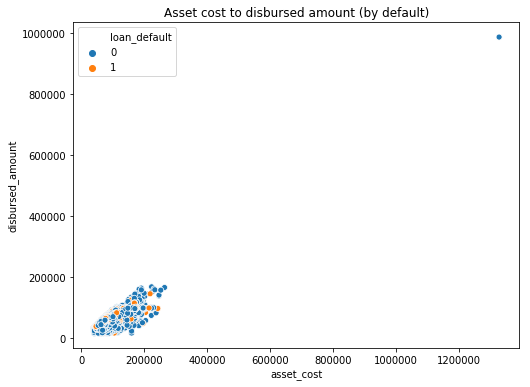

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=loan.asset_cost, y=loan.disbursed_amount, hue=loan['loan_default'])
plt.title('Asset cost to disbursed amount (by default)')
plt.show()

> As assumed, there's a positive correlation between the two features.

> I'll drop the outlier for reducing noise

In [17]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan.asset_cost>400000].index, inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90983
number of samples after removing outlier: 90982


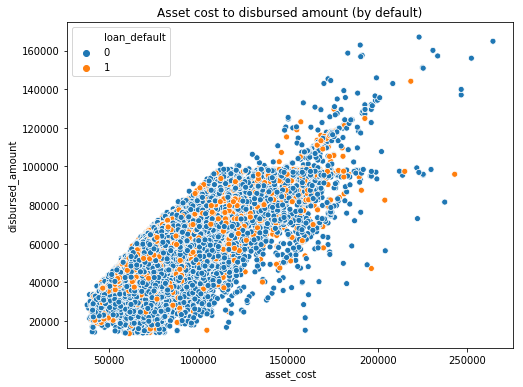

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=loan.asset_cost, y=loan.disbursed_amount, hue=loan['loan_default'])
plt.title('Asset cost to disbursed amount (by default)')
plt.show()

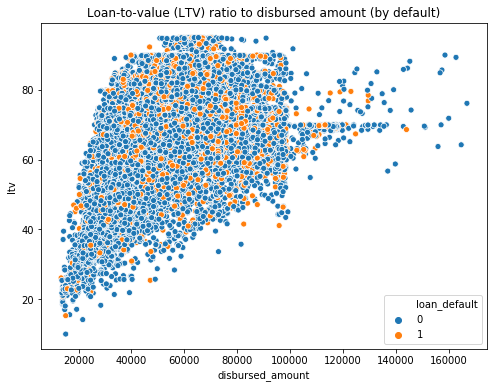

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(loan.disbursed_amount,loan.ltv, hue=loan.loan_default)
plt.title('Loan-to-value (LTV) ratio to disbursed amount (by default)')
plt.show()

In [20]:
loan.ltv.describe()

count   90982.000000
mean       74.232188
std        11.708235
min        10.030000
25%        68.050000
50%        76.180000
75%        83.400000
max        95.000000
Name: ltv, dtype: float64

> As assumed, Loan-to-value has positive correlation to disbursed amount and the ratio doesn't exceeding 100.

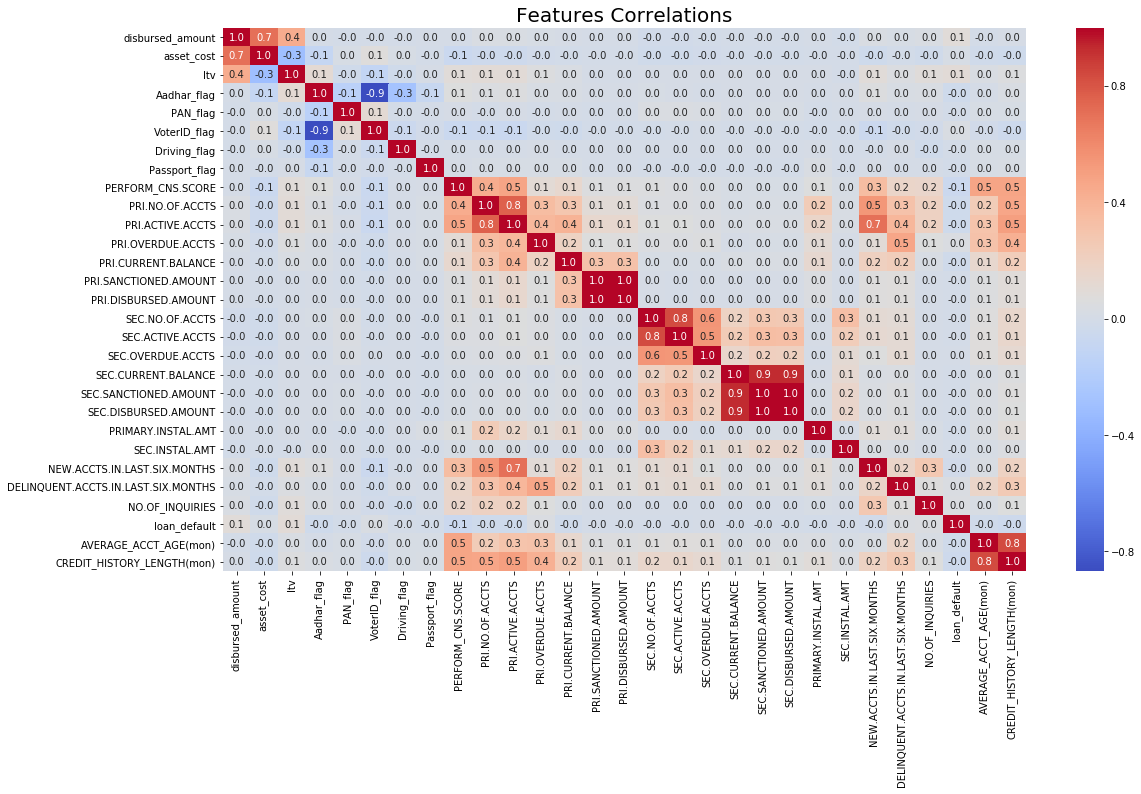

In [21]:
loan_corr = loan.corr()

plt.figure(figsize=(18,10))
sns.heatmap(loan_corr, cmap='coolwarm',annot=True, annot_kws={"size": 10},fmt='.1f')
plt.title('Features Correlations', fontsize=20)
plt.show()

> `volterID_flag` & `Aadhar_flag` are highly correlated. couldn't find interpretation of them online for explaining that relationship.

> Some features have multicollinearity (fully correlated to each other [==1]). It's better to drop one of them for better performance of the models (especially linear models).

> `AVERAGE_ACCT_AGE(mon)` & `CREDIT_HISTORY_LENGTH(mon)` also highly correlated but it makes sense so I'll keep them both in case togather they provide more information.

**Dropping features with multicollinearity:**

In [22]:
# only 5.7% of the data isn't identical between these two features so I'll drop one of them

print(f"{((loan.loc[:,'PRI.SANCTIONED.AMOUNT']!=loan.loc[:,'PRI.DISBURSED.AMOUNT']).sum())/loan.shape[0]*100 :.2f}% of the data was different")
loan.drop(columns='PRI.DISBURSED.AMOUNT', inplace=True)

5.68% of the data was different


In [23]:
# only 0.3% of the data isn't identical between these two features so I'll drop one of them 

print(f"{((loan.loc[:,'SEC.SANCTIONED.AMOUNT']!=loan.loc[:,'SEC.DISBURSED.AMOUNT']).sum())/loan.shape[0]*100 :.2f}% of the data was different")
loan.drop(columns='SEC.SANCTIONED.AMOUNT', inplace=True)

0.28% of the data was different


### Looking for other outliers

In [24]:
loan.describe([0.01,0.25,0.5,0.75,0.999])

,disbursed_amount,asset_cost,ltv,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,AVERAGE_ACCT_AGE(mon),CREDIT_HISTORY_LENGTH(mon)
count,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000,90982.000000
mean,54118.004660,76004.419490,74.232188,0.819514,0.079389,0.163527,0.025895,0.002374,288.898991,2.324174,0.997505,0.146480,158196.615825,214783.690290,0.057374,0.026676,0.007518,5840.109736,7233.177980,10175.071663,248.424337,0.366809,0.091677,0.200985,0.201952,8.757677,15.750786
std,12179.434514,17274.020960,11.708235,0.384594,0.270347,0.369848,0.158824,0.048667,340.573507,4.845144,1.862328,0.527675,952569.395138,3517765.306104,0.635093,0.309876,0.114408,219034.701788,209751.065560,133768.629754,8867.765830,0.922286,0.370698,0.706985,0.401459,15.049642,27.917976
min,13369.000000,37658.000000,10.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6678296.000000,0.000000,0.000000,0.000000,0.000000,-239782.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,26178.050000,49575.620000,38.408100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47145.000000,66242.000000,68.050000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53734.000000,71418.000000,76.180000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60213.000000,79500.000000,83.400000,1.000000,0.000000,0.000000,0.000000,0.000000,680.000000,3.000000,1.000000,0.000000,29829.750000,56476.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1843.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,23.000000
99.9%,117448.000000,182719.000000,94.620190,1.000000,1.000000,1.000000,1.000000,1.000000,853.000000,47.000000,16.000000,5.000000,10027765.619001,12523397.987001,8.000000,4.000000,1.000000,1153532.230000,1529829.875000,1118570.683000,42694.332000,8.000000,4.000000,8.000000,1.000000,129.019000,194.019000
max,166972.000000,264500.000000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,890.000000,271.000000,65.000000,23.000000,96524920.000000,1000000000.000000,46.000000,26.000000,8.000000,36032852.000000,30000000.000000,20766553.000000,1231166.000000,35.000000,12.000000,23.000000,1.000000,369.000000,449.000000


**NOTE:** I could have build a function to run all over the columns and remove automaticly all the data exceeding the 99.9% percentile (or any other treshold) but there are not too many features so I rather do it manually for better decision making.

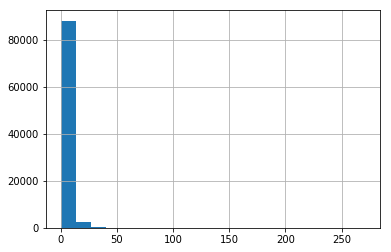

90 outliers (exceeding the 99.9% percentile) will be removed


In [25]:
# exploring 'PRI.NO.OF.ACCTS' for outliers:

loan['PRI.NO.OF.ACCTS'].hist(bins=20)
plt.show()

print(f"{(loan['PRI.NO.OF.ACCTS'].loc[loan['PRI.NO.OF.ACCTS']>47]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [26]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['PRI.NO.OF.ACCTS']>47,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90982
number of samples after removing outlier: 90892


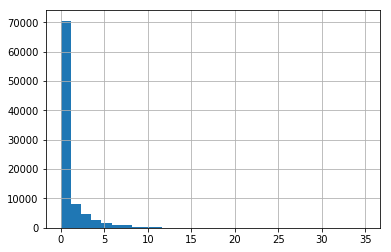

56 outliers (exceeding the 99.9% percentile) will be removed


In [27]:
# exploring 'PRI.ACTIVE.ACCTS' for outliers:

loan['PRI.ACTIVE.ACCTS'].hist(bins=30)
plt.show()

print(f"{(loan['PRI.ACTIVE.ACCTS'].loc[loan['PRI.ACTIVE.ACCTS']>16]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [28]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['PRI.ACTIVE.ACCTS']>16,'PRI.ACTIVE.ACCTS'].index, inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90892
number of samples after removing outlier: 90836


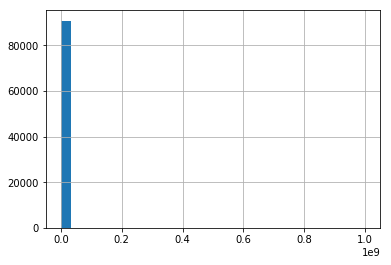

74 outliers (exceeding the 99.9% percentile) will be removed


In [29]:
# exploring 'PRI.SANCTIONED.AMOUNT' for outliers:

loan['PRI.SANCTIONED.AMOUNT'].hist(bins=30)
plt.show()

print(f"{(loan['PRI.SANCTIONED.AMOUNT'].loc[loan['PRI.SANCTIONED.AMOUNT']>12523397]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [30]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['PRI.SANCTIONED.AMOUNT']>12523397,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90836
number of samples after removing outlier: 90762


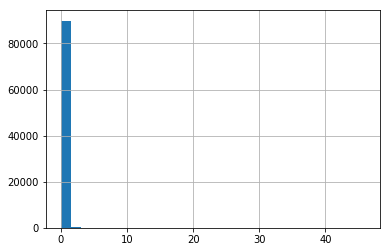

82 outliers (exceeding the 99.9% percentile) will be removed


In [31]:
# exploring 'SEC.NO.OF.ACCTS' for outliers:

loan['SEC.NO.OF.ACCTS'].hist(bins=30)
plt.show()

print(f"{(loan['SEC.NO.OF.ACCTS'].loc[loan['SEC.NO.OF.ACCTS']>8]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [32]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['SEC.NO.OF.ACCTS']>8,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90762
number of samples after removing outlier: 90680


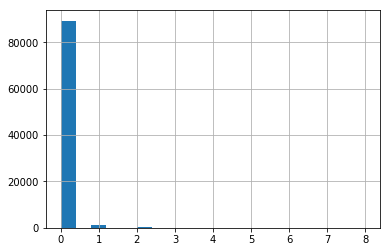

23 outliers (exceeding the 99.9% percentile) will be removed


In [33]:
# exploring 'SEC.ACTIVE.ACCTS' for outliers:

loan['SEC.ACTIVE.ACCTS'].hist(bins=20)
plt.show()

print(f"{(loan['SEC.ACTIVE.ACCTS'].loc[loan['SEC.ACTIVE.ACCTS']>4]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [34]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['SEC.ACTIVE.ACCTS']>4,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90680
number of samples after removing outlier: 90657


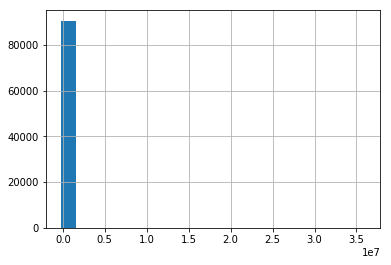

71 outliers (exceeding the 99.9% percentile) will be removed


In [35]:
# exploring 'SEC.CURRENT.BALANCE' for outliers:

loan['SEC.CURRENT.BALANCE'].hist(bins=20)
plt.show()

print(f"{(loan['SEC.CURRENT.BALANCE'].loc[loan['SEC.CURRENT.BALANCE']>1153532]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [36]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['SEC.CURRENT.BALANCE']>1153532,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90657
number of samples after removing outlier: 90586


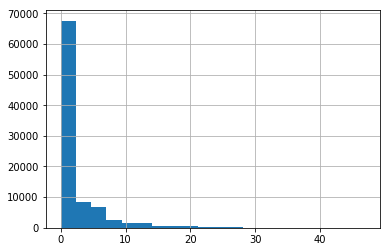

0 outliers (exceeding the 99.9% percentile) will be removed


In [37]:
# exploring 'PRI.NO.OF.ACCTS' for outliers:

loan['PRI.NO.OF.ACCTS'].hist(bins=20)
plt.show()

print(f"{(loan['PRI.NO.OF.ACCTS'].loc[loan['PRI.NO.OF.ACCTS']>47]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [38]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['PRI.NO.OF.ACCTS']>47,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90586
number of samples after removing outlier: 90586


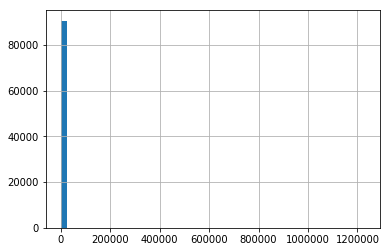

58 outliers (exceeding the 99.9% percentile) will be removed


In [39]:
# exploring 'SEC.INSTAL.AMT' for outliers:

loan['SEC.INSTAL.AMT'].hist(bins=50)
plt.show()

print(f"{(loan['SEC.INSTAL.AMT'].loc[loan['SEC.INSTAL.AMT']>42694]).count()} outliers (exceeding the 99.9% percentile) will be removed")

In [40]:
print(f'number of samples before removing outlier: {loan.shape[0]}')
loan.drop(index=loan.loc[loan['SEC.INSTAL.AMT']>42694,:].index,inplace=True)
print(f'number of samples after removing outlier: {loan.shape[0]}')

number of samples before removing outlier: 90586
number of samples after removing outlier: 90528


rest of the feature I'll keep as is.

## Feature engineering

adding the age of the borrower as a new feature:

In [41]:
loan['borrower_age'] = 2019 - loan['Date.of.Birth'].dt.year

In [44]:
print(f"{loan.loc[loan.borrower_age<0,'Date.of.Birth'].count()} samples has incorrect date of birth (year greater than 2019)")

2216 samples has incorrect date of birth (year greater than 2019)


In [45]:
loan.borrower_age[loan.borrower_age > 0].describe()

count   88312.000000
mean       34.431765
std         9.338356
min        19.000000
25%        27.000000
50%        33.000000
75%        41.000000
max        65.000000
Name: borrower_age, dtype: float64

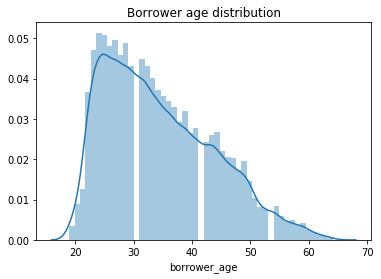

In [46]:
sns.distplot(loan.borrower_age[loan.borrower_age > 0], bins=50)
plt.title('Borrower age distribution')
plt.show()

In [47]:
# right skew distribution.
# for bad age values I'll assign the median of the correct age data

loan.borrower_age[loan.borrower_age < 0] = loan.borrower_age[loan.borrower_age > 0].median()

## Filling Missing Values

One (binary) feature have quite a lot of missing values. I don't want to loss this information so I'll try to fill it using classification ML model. Due time consuming reasons, I'll predict the missing values with 2 basic models and choose the best fit (also I won't be using categorical features and won't be validating the model for variance nor overfit).

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

**Function for fill NA values:**

In [49]:
def fill_na_by_clf(df,col):
    
    # estimating a missing value in column according to other available features.
    
    df_corr = loan.corr()
    missing_values = df.loc[df[col].isna(),df_corr.index]

    # if there are no missing value - exit the function
    if missing_values.shape[0]==0 or missing_values.dropna(how='any').shape[0]==0:
        return None

    model_cols = (df_corr.index.tolist())
    model_cols.append(col)

    model_df = df.loc[~df.index.isin(missing_values.index),model_cols]

    X = model_df.drop(columns=col)
    y = model_df[col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

    # Logistic regression
    steps = [('scaler', MinMaxScaler()), 
             ('model', LogisticRegression())]

    pipe = Pipeline(steps)

    params = {'scaler': [MinMaxScaler(), StandardScaler()], 
             'model__C': [0.5,2,5,7,10],
             'model__solver':['lbfgs','liblinear']}


    lm_gs = GridSearchCV(pipe, param_grid=params, cv=5, return_train_score=False, n_jobs=-1)
    lm_gs.fit(X_train, y_train)

    lm_estimator = lm_gs.best_estimator_
    lm_y_pred = lm_estimator.predict(X_test)
    lm_y_train_pred = lm_estimator.predict(X_train)
    lm_train_score = lm_gs.score(X_train,y_train)
    lm_score = lm_gs.score(X_test,y_test)

    # Random Forest 
    params= {'max_depth': range (3, 10),
             'min_samples_leaf': [5,10,20,30,40,50],
            'criterion': ['entropy','gini']}

    tree_gs = GridSearchCV(RandomForestClassifier(n_estimators=50), params, cv=5,
                           return_train_score=False,n_jobs=-1)

    tree_gs.fit(X_train, y_train)
    tree_estimator = tree_gs.best_estimator_

    # predicting the target class
    tree_y_pred = tree_estimator.predict(X_test)
    tree_y_train_pred = tree_estimator.predict(X_train)
    tree_score = tree_gs.score(X_test,y_test)
    tree_train_score = tree_gs.score(X_train,y_train)


    # comparing the two models:
    score = {}
    score['lm_score'] = [lm_score,lm_train_score]
    score['tree_score'] = [tree_score,tree_train_score]

    score_table = pd.DataFrame.from_dict(score, orient='index').rename(columns={0:'test_score',1:'train_score'})
    best_estimator = score_table.test_score.idxmax().split('_')[0] + '_estimator'

    # predicting the missing values:
    model_estimator = eval(best_estimator)

    missing_values[col] = model_estimator.predict(missing_values)

    return missing_values.loc[:,col]

In [50]:
loan['Employment.Type'].fillna(fill_na_by_clf(loan,'Employment.Type'),inplace=True)

In [51]:
# checking that there are no missing values:

loan.isna().sum().sum()

0

### Save the new df for modeling

In [52]:
loan.to_csv('new_loan_data.csv')